In [1]:
import os
import nltk
import pickle
import requests
from io import BytesIO
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO  #helper tool to work with COCO dataset
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence # to make sure that embeddings are of same length

In [2]:
os.makedirs('data_dir', exist_ok = True)
os.chdir("/content/data_dir")
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [3]:
import os
import urllib

os.chdir('/content/data_dir/cocoapi')

annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014, 'annotations_trainval2014.zip')
urllib.request.urlretrieve(image_info_test2014, 'image_info_test2014.zip')

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7f87180da8f0>)

In [4]:
import zipfile

with zipfile.ZipFile('annotations_trainval2014.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data_dir/cocoapi')

try:
  os.remove('annotations_trainval2014.zip')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data_dir/cocoapi')

try:
  os.remove('image_info_test2014.zip')
except:
  None



In [5]:
# initialize and verify the loaded data

os.chdir('/content/data_dir/cocoapi/annotations')

dataType = 'val2014'
annFile = 'instances_{}.json'.format(dataType)
print(annFile)
coco = COCO(annFile)

captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())
print('Number of annotations: {}'.format(len(ids)))

instances_val2014.json
loading annotations into memory...
Done (t=5.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
Number of annotations: 291875


loading annotations into memory...
Done (t=4.99s)
creating index...
index created!
http://images.cocodataset.org/val2014/COCO_val2014_000000356623.jpg
Number of annotations: [568579, 571780, 575755, 576775, 576835]

Some people riding some motorcycles through a rock tunnel.
Three motorcycles ride under a tunnel made from rock.
Group of motocyclists during ride on mountainous road with rock archway.
People on motorcycles ride under a hole in a rock.
a group of people on motorcycles riding through  a rock tunnel and a sign says falling rock


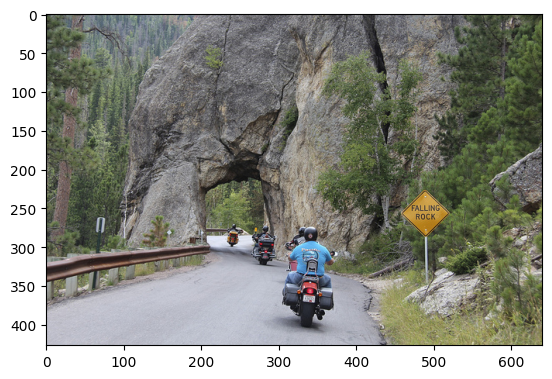

In [6]:
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline

coco = COCO(annFile)
ids = list(coco.anns.keys())
ann_id = np.random.choice(ids)
ann = coco.anns[ann_id]
img_id = ann['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

print(url)

I = io.imread(url)
plt.imshow(I)

annIds = coco_caps.getAnnIds(img_id)
print('Number of annotations:', annIds)
print()
anns = coco_caps.loadAnns(annIds)
coco.showAnns(anns)

## Preprocessing Text Data

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
class Vocab(object):
  """Simple Vocabulary Wrapper"""

  def __init__(self):

    self.w2i = {}
    self.i2w = {}
    self.index = 0

  def __call__(self, token):
    if not token in self.w2i:
      return self.w2i['<unk>']
    return self.w2i[token]

  def __len__(self):
    return len(self.w2i)

  def add_token(self, token):
    if not token in self.w2i:
      self.w2i[token] = self.index
      self.i2w[self.index] = token
      self.index += 1

def build_vocabulary(json, threshold):
  """Build a simple vocabulary wrapper."""

  coco = COCO(json)
  counter = Counter()
  ids = coco.anns.keys()

  for i, id in enumerate(ids):
    caption = str(coco.anns[id]['caption'])
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)

    if (i+1) % 1000 == 0:
      print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
    else:
      print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

  tokens = [token for token, cnt in counter.items() if cnt >= threshold]

  # creating a vocab wrapper and adding some special tokens

  vocab = Vocab()
  vocab.add_token('<pad>')
  vocab.add_token('<start>')
  vocab.add_token('<end>')
  vocab.add_token('<unk>')

  # Adding the words to vocabulary

  for i, token in enumerate(tokens):
    vocab.add_token(token)

  return vocab

import pickle

vocab = build_vocabulary(json="/content/data_dir/cocoapi/annotations/captions_train2014.json", threshold=4)
print("Vocabulary Build Successfully!!")
vocab_path = '/content/data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

Streaming output truncated to the last 5000 lines.
[409117/414113] Tokenized the captions.
[409118/414113] Tokenized the captions.
[409119/414113] Tokenized the captions.
[409120/414113] Tokenized the captions.
[409121/414113] Tokenized the captions.
[409122/414113] Tokenized the captions.
[409123/414113] Tokenized the captions.
[409124/414113] Tokenized the captions.
[409125/414113] Tokenized the captions.
[409126/414113] Tokenized the captions.
[409127/414113] Tokenized the captions.
[409128/414113] Tokenized the captions.
[409129/414113] Tokenized the captions.
[409130/414113] Tokenized the captions.
[409131/414113] Tokenized the captions.
[409132/414113] Tokenized the captions.
[409133/414113] Tokenized the captions.
[409134/414113] Tokenized the captions.
[409135/414113] Tokenized the captions.
[409136/414113] Tokenized the captions.
[409137/414113] Tokenized the captions.
[409138/414113] Tokenized the captions.
[409139/414113] Tokenized the captions.
[409140/414113] Tokenized the

## Preprocessing the Image Data

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import os
import zipfile

# Define paths
zip_file_path = '/content/drive/MyDrive/Assignments/resized_train2014.zip'
extract_path = '/content/data_dir/resized_train2014'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List files in the extraction directory
files = os.listdir(extract_path)

# Count the number of files
num_files = len(files)

print(f"Total number of files extracted: {num_files}")


Total number of files extracted: 82782


In [11]:
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'json_images' and save into 'output_path'."""
    url_list = [image_path]

    for i, j in enumerate(url_list):
      response = requests.get(j)
      if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image = image.resize(shape, Image.ANTIALIAS)

        # Define output file path
        output_file_path = os.path.join(output_path, os.path.basename(j))
        image.save(output_file_path, image.format)
        print(f"{image} image saved")

      else:
          print(f"Failed to download image from {j}")

image_path = 'http://images.cocodataset.org/train2014/COCO_train2014_000000447457.jpg'
output_path = '/content/data_dir/resized_train2014/'
# output_path = '/content/data_dir/resized_train2014'
image_shape = (256, 256)

reshape_images(image_path, output_path, image_shape)


<PIL.Image.Image image mode=RGB size=256x256 at 0x7F870B44B010> image saved


<ipython-input-11-b28d6befa789>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(shape, Image.ANTIALIAS)


In [13]:
files = os.listdir("/content/data_dir/resized_train2014")

if "COCO_train2014_000000447457.jpg" in files:
  print("yes")

# Count the number of files
num_files = len(files)

print(f"Total number of files extracted: {num_files}")

yes
Total number of files extracted: 82783


In [12]:
# import shutil

# # Specify the path to your folder
# folder_path = '/content/data_dir/resized_train2014'  # Change to your folder path
# # Specify the path where the zip file will be saved
# zip_path = '/content/data_dir/resized_train2014.zip'  # Change to your desired zip file path

# # Create a zip file
# shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


In [14]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth

    def __len__(self):
        return len(self.indices)


def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)

    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return custom_data_loader

In [15]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features


class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

In [18]:
# Device configuration
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')


# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build data loader
custom_data_loader = get_loader('/content/data_dir/resized_train2014', '/content/data_dir/cocoapi/annotations/captions_train2014.json', vocabulary,
                         transform, 128,
                         shuffle=True, num_workers=2)


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(3):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))

        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

cuda
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2100, Perplexity: 9996.4447
Epoch [0/5], Step [10/3236], Loss: 5.6937, Perplexity: 296.9771
Epoch [0/5], Step [20/3236], Loss: 5.3201, Perplexity: 204.4144
Epoch [0/5], Step [30/3236], Loss: 4.9033, Perplexity: 134.7272
Epoch [0/5], Step [40/3236], Loss: 4.4966, Perplexity: 89.7095
Epoch [0/5], Step [50/3236], Loss: 4.4007, Perplexity: 81.5044
Epoch [0/5], Step [60/3236], Loss: 4.3209, Perplexity: 75.2561
Epoch [0/5], Step [70/3236], Loss: 3.9548, Perplexity: 52.1844
Epoch [0/5], Step [80/3236], Loss: 3.8127, Perplexity: 45.2737
Epoch [0/5], Step [90/3236], Loss: 3.8209, Perplexity: 45.6473
Epoch [0/5], Step [100/3236], Loss: 3.8623, Perplexity: 47.5763
Epoch [0/5], Step [110/3236], Loss: 3.7892, Perplexity: 44.2196
Epoch [0/5], Step [120/3236], Loss: 3.7263, Perplexity: 41.5249
Epoch [0/5], Step [130/3236], Loss: 3.6789, Perplexity: 39.6022
Epoch [0/5], Step [140

<start> a dog sitting on a bench with a blue and white dog . <end>


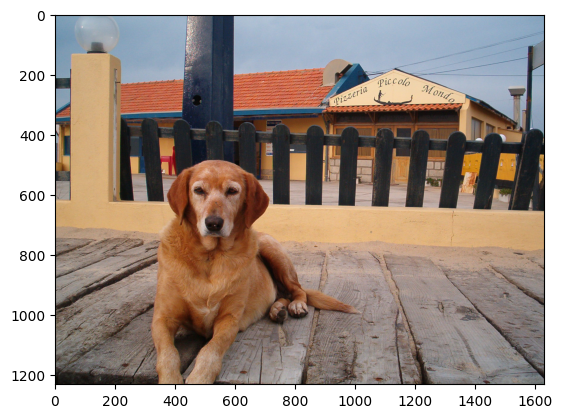

In [19]:
image_file_path = '/content/sample.jpg'


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))